# Proyecto de Machine Learning: Predicción de Supervivencia en el Titanic

## 1. Introducción al Proyecto y Definición del Problema

### Objetivo
El objetivo de este proyecto es aplicar un flujo de trabajo completo de Machine Learning para predecir si un pasajero del Titanic sobrevivió o no, basándonos en sus características.

### Problema de Negocio y Mapeo a ML
- **Problema**: Entender los factores que llevaron a una mayor probabilidad de supervivencia en el naufragio del Titanic.
- **Problema de ML**: Se traduce en un problema de **clasificación binaria supervisada**.
- **Variable Objetivo**: `Survived` (0 = No, 1 = Sí).
- **Features**: Características de los pasajeros como clase, sexo, edad, etc.

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('ggplot')
%matplotlib inline

## 2. Adquisición y Análisis Exploratorio de Datos (EDA)

### Objetivo
Cargar los datos, entender su estructura, identificar problemas como valores faltantes y visualizar patrones clave.

In [2]:
# 2.1 Carga de datos
df = pd.read_csv('Titanic-Dataset.csv')

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas del dataset:")
df.head()

=== INFORMACIÓN DEL DATASET ===
Dimensiones del dataset: (891, 12)

Primeras 5 filas del dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 2.2 Tipos de Datos e Información Básica
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
df.info()

=== INFORMACIÓN GENERAL DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 2.3 Análisis de Valores Faltantes
print("=== ANÁLISIS DE VALORES FALTANTES ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
})

print(missing_df[missing_df['Valores_Faltantes'] > 0].sort_values(by='Porcentaje', ascending=False))

=== ANÁLISIS DE VALORES FALTANTES ===
     Columna  Valores_Faltantes  Porcentaje
10     Cabin                687   77.104377
5        Age                177   19.865320
11  Embarked                  2    0.224467


=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (SURVIVED) ===
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


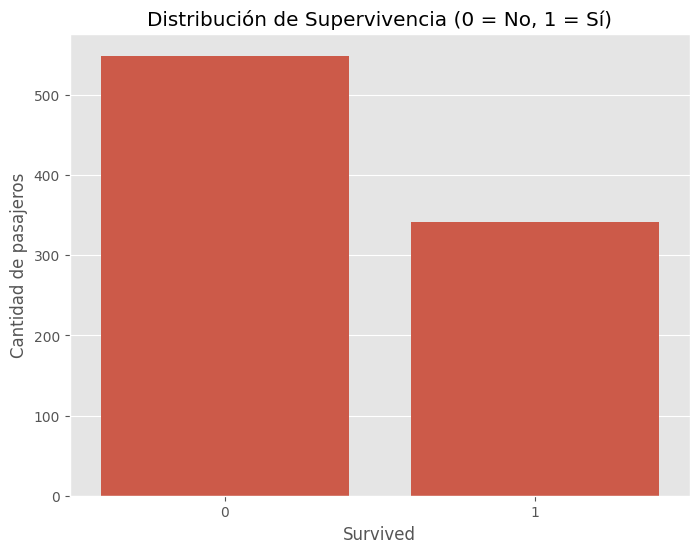

In [5]:
# 2.4 Análisis de la Variable Objetivo
print("=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (SURVIVED) ===")
print(df['Survived'].value_counts(normalize=True) * 100)

# Visualización
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df)
plt.title('Distribución de Supervivencia (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de pasajeros')
plt.show()

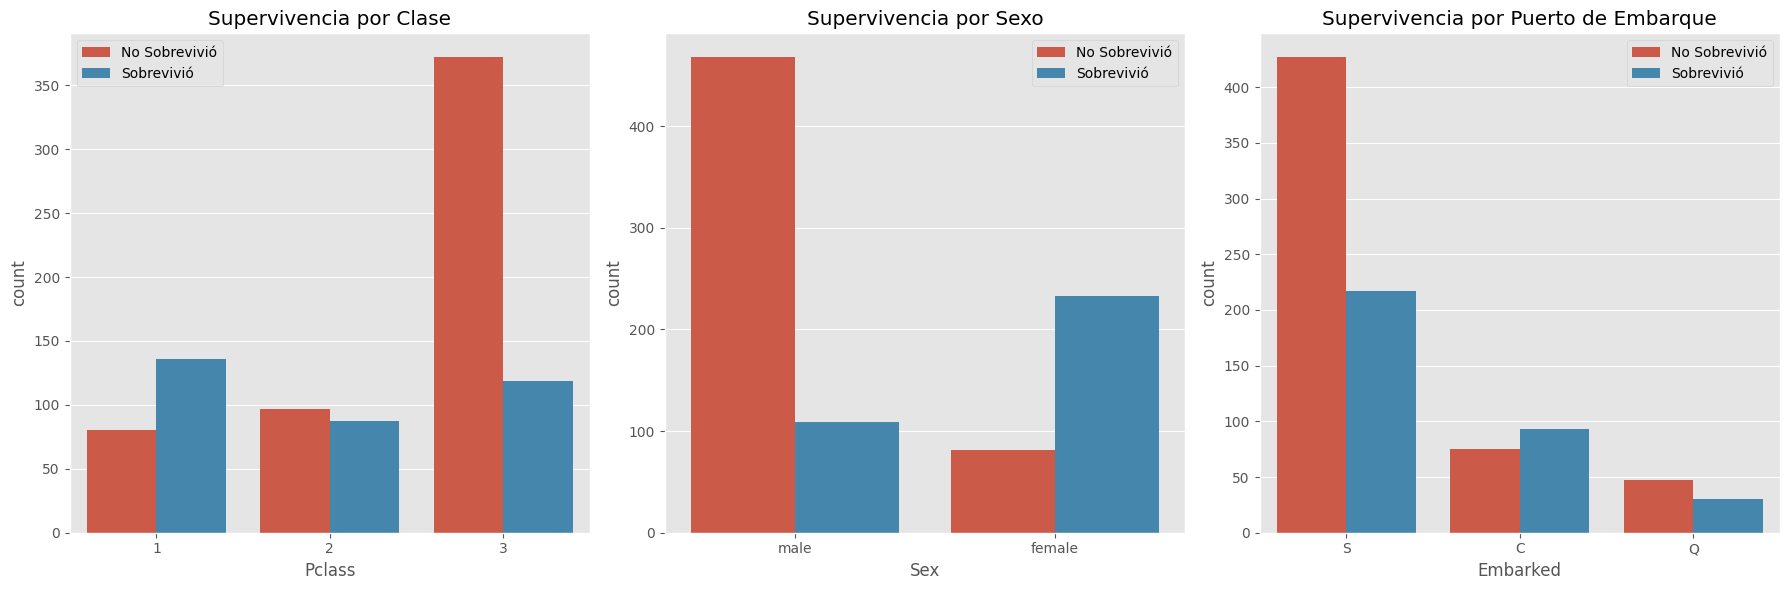

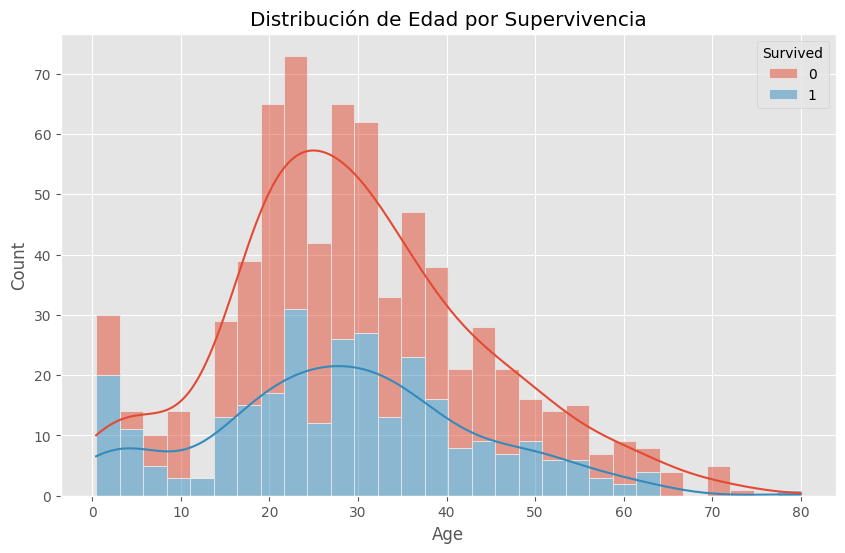

In [6]:
# 2.5 Exploración Visual de Datos

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pclass vs Survived
sns.countplot(x='Pclass', hue='Survived', data=df, ax=axes[0])
axes[0].set_title('Supervivencia por Clase')
axes[0].legend(['No Sobrevivió', 'Sobrevivió'])

# Sex vs Survived
sns.countplot(x='Sex', hue='Survived', data=df, ax=axes[1])
axes[1].set_title('Supervivencia por Sexo')
axes[1].legend(['No Sobrevivió', 'Sobrevivió'])

# Embarked vs Survived
sns.countplot(x='Embarked', hue='Survived', data=df, ax=axes[2])
axes[2].set_title('Supervivencia por Puerto de Embarque')
axes[2].legend(['No Sobrevivió', 'Sobrevivió'])

plt.tight_layout()
plt.show()

# Age vs Survived
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', bins=30, kde=True)
plt.title('Distribución de Edad por Supervivencia')
plt.show()

## 3. Ingeniería de Características y Preprocesamiento

### Objetivo
Transformar los datos crudos para que sean adecuados para el modelado. Esto incluye:
- Imputar valores faltantes.
- Crear nuevas características (feature engineering).
- Codificar variables categóricas.
- Escalar variables numéricas.

In [8]:
# Separar características (X) y variable objetivo (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Eliminar columnas que no aportan o son difíciles de usar
# Cabin tiene demasiados nulos. PassengerId, Name y Ticket son identificadores únicos.
X = X.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1)

print("Columnas restantes en X:")
print(X.columns)

Columnas restantes en X:
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')


In [9]:
# Identificar columnas numéricas y categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Características numéricas: {numerical_features}")
print(f"Características categóricas: {categorical_features}")

# Crear pipelines de preprocesamiento para cada tipo de dato

# Para datos numéricos: imputar con la mediana y luego escalar
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para datos categóricos: imputar con la moda y luego aplicar One-Hot Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los pipelines en un único preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

Características numéricas: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Características categóricas: ['Sex', 'Embarked']


## 4. Construcción y Evaluación del Modelo

### Objetivo
- Dividir los datos en conjuntos de entrenamiento y prueba.
- Entrenar diferentes modelos de clasificación.
- Evaluar y comparar su rendimiento para seleccionar el mejor.
- Optimizar el mejor modelo.
- Realizar una evaluación final en el conjunto de prueba.

In [10]:
# 4.1 División de Datos
# Se usa stratify=y para mantener la proporción de sobrevivientes en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 712 muestras
Tamaño del conjunto de prueba: 179 muestras


In [11]:
# 4.2 Entrenamiento de Múltiples Modelos

# Definir los modelos a probar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    # Crear el pipeline completo: preprocesador + modelo
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Entrenar
    model_pipeline.fit(X_train, y_train)
    
    # Predecir
    y_pred = model_pipeline.predict(X_test)
    
    # Evaluar
    print(f"\n=== RESULTADOS PARA {name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")


=== RESULTADOS PARA Logistic Regression ===
Accuracy: 0.8045
Precision: 0.7931
Recall: 0.6667
F1-Score: 0.7244

=== RESULTADOS PARA Random Forest ===
Accuracy: 0.8156
Precision: 0.8000
Recall: 0.6957
F1-Score: 0.7442


### 4.3 Optimización de Hiperparámetros (Random Forest)
El Random Forest mostró un buen rendimiento inicial. Ahora optimizaremos sus hiperparámetros para intentar mejorarlo.

In [12]:
# Crear el pipeline solo con el preprocesador y el clasificador base
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definir el grid de parámetros a probar
# Ojo: los parámetros del clasificador deben prefijarse con 'classifier__'
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

print("Iniciando optimización de hiperparámetros...")
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

Iniciando optimización de hiperparámetros...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Mejores parámetros encontrados: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}
Mejor F1-Score (CV): 0.7542


### 4.4 Evaluación Final del Modelo Optimizado
Ahora evaluamos el mejor modelo encontrado por `GridSearchCV` en el conjunto de prueba, que el modelo nunca ha visto.

=== MÉTRICAS FINALES EN CONJUNTO DE PRUEBA ===
               precision    recall  f1-score   support

No Sobrevivió       0.80      0.92      0.85       110
   Sobrevivió       0.83      0.62      0.71        69

     accuracy                           0.80       179
    macro avg       0.81      0.77      0.78       179
 weighted avg       0.81      0.80      0.80       179



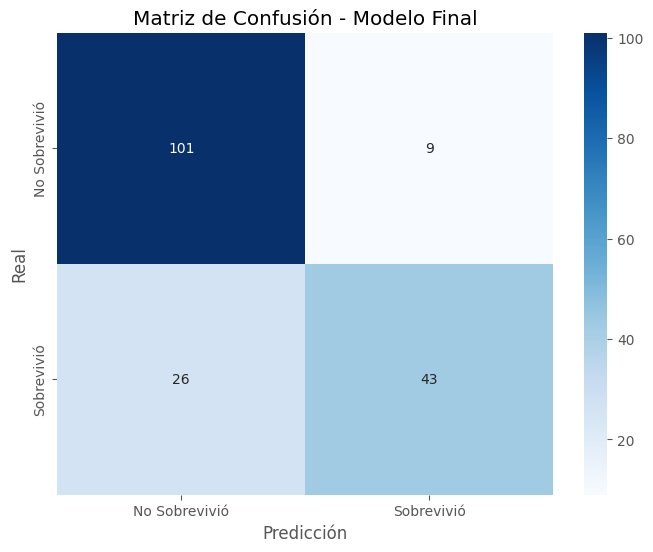

In [13]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones en el conjunto de prueba
y_pred_final = best_model.predict(X_test)

print("=== MÉTRICAS FINALES EN CONJUNTO DE PRUEBA ===")
print(classification_report(y_test, y_pred_final, target_names=['No Sobrevivió', 'Sobrevivió']))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Sobrevivió', 'Sobrevivió'], 
            yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.title('Matriz de Confusión - Modelo Final')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### 4.5 Análisis de Importancia de Características
Podemos extraer la importancia que el modelo Random Forest le dio a cada característica para entender qué factores fueron más decisivos en sus predicciones.

=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===
      feature  importance
6    Sex_male    0.256763
5  Sex_female    0.195154
4        Fare    0.177755
1         Age    0.137598
0      Pclass    0.126859
2       SibSp    0.036749
3       Parch    0.028929
9  Embarked_S    0.018824
7  Embarked_C    0.013422
8  Embarked_Q    0.007947


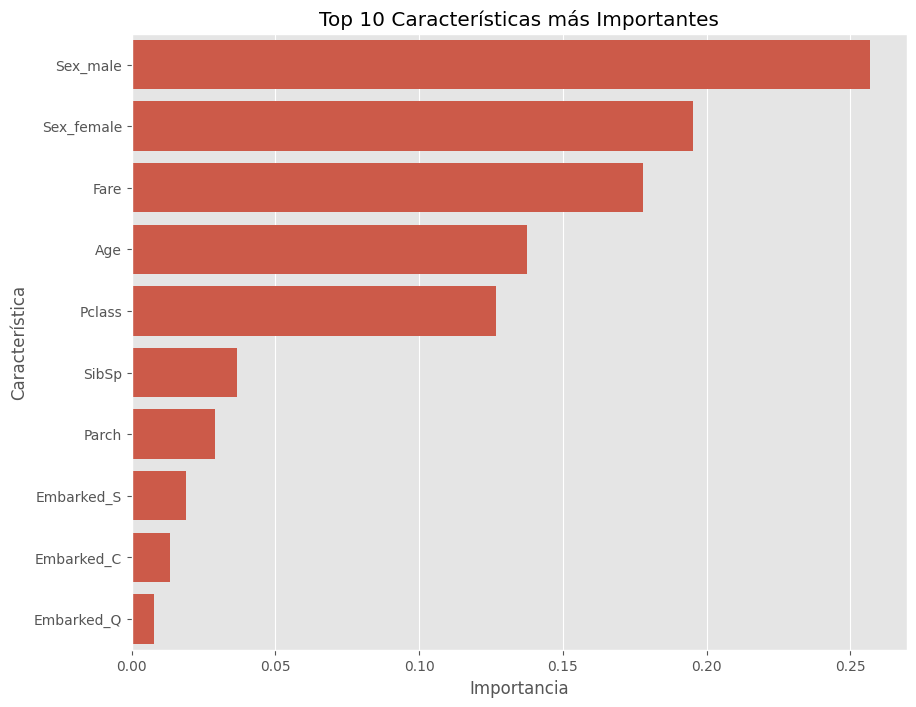

In [14]:
# Extraer los nombres de las características después del OneHotEncoding
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Extraer las importancias
importances = best_model.named_steps['classifier'].feature_importances_

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===")
print(feature_importance_df.head(10))

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Características más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

## 5. Conclusión

En este proyecto, hemos seguido un flujo de trabajo estructurado de Machine Learning para abordar el problema de predicción de supervivencia en el Titanic.

- **Análisis Exploratorio (EDA)**: Identificamos que características como el **sexo**, la **clase del ticket (Pclass)** y la **edad** eran determinantes para la supervivencia.
- **Preprocesamiento**: Se construyó un `Pipeline` robusto para manejar valores faltantes, codificar variables categóricas y escalar datos numéricos de forma automática y reproducible.
- **Modelado**: El modelo `RandomForestClassifier`, después de ser optimizado, logró un rendimiento sólido, identificando correctamente a una gran parte de los sobrevivientes y no sobrevivientes.
- **Interpretabilidad**: El análisis de importancia de características confirmó nuestras hipótesis iniciales del EDA, mostrando que el **sexo** y la **edad** son los predictores más fuertes, seguidos de la **tarifa (Fare)** y la **clase (Pclass)**.

Este enfoque no solo produce un modelo predictivo, sino que también proporciona insights valiosos sobre la naturaleza del problema.